### Imports

In [301]:
# import libraries
%matplotlib inline

import pandas as pd
from scipy import stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import mahalanobis
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors


### Data Source
First, I searched for properties in Carson, Norwalk, Lakewood, Whittier and Compton California on Zillow. Then, I scrapped this data using the Property Search & Detail Tool with an API Key from Scrapeak.

In [302]:
# Upload SoCal Real Estate data:
listings = pd.read_csv('socal_RealEstate.csv')

In [303]:
# Make a copy of data:
listings_copy = listings.copy()

### Data Understanding

In [304]:
socal_listings = listings_copy
socal_listings.head()

,zpid,streetName,city,state,zipcode,latitude,longitude,price,bathrooms,bedrooms,...,newConstructionType,datePriceChanged,priceReduction,priceChange,is_openHouse,openHouse,open_house_showing,imgSrc,homeDetailUrl,price_to_rent_ratio
0,21402681,14502 Graystone Ave,Norwalk,CA,90650,33.899815,-118.093700,675000,2,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://photos.zillowstatic.com/fp/2e43998995f...,https://www.zillow.com/homedetails/14502-Grays...,252.544208
1,21438254,9345 Firebird Ave,Whittier,CA,90605,33.951202,-118.038216,699900,2,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://photos.zillowstatic.com/fp/ccb0de1d0b4...,https://www.zillow.com/homedetails/9345-Firebi...,198.471798
2,21377623,12316 Newgate Ave,Whittier,CA,90605,33.919643,-118.040120,725000,2,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://photos.zillowstatic.com/fp/48e84309b0c...,https://www.zillow.com/homedetails/12316-Newga...,206.319703
3,21284734,19922 Enslow Dr,Carson,CA,90746,33.850390,-118.256000,789900,2,3,...,NaN,NaN,NaN,NaN,True,Sun. 1am-4pm,"[{'open_house_start': 1704618000000, 'open_hou...",https://photos.zillowstatic.com/fp/ca89f4bc9f1...,https://www.zillow.com/homedetails/19922-Enslo...,NaN
4,21174714,6121 Droxford St,Lakewood,CA,90713,33.860863,-118.112656,750000,2,4,...,NaN,NaN,NaN,NaN,True,Sat. 11am-2pm,"[{'open_house_start': 1704567600000, 'open_hou...",https://photos.zillowstatic.com/fp/1eefead737a...,https://www.zillow.com/homedetails/6121-Droxfo...,184.261905


In [305]:
# Initial Analysis:
socal_listings.shape

(89, 34)

In [306]:
socal_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 34 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   zpid                     89 non-null     int64  
 1   streetName               89 non-null     object 
 2   city                     89 non-null     object 
 3   state                    89 non-null     object 
 4   zipcode                  89 non-null     int64  
 5   latitude                 89 non-null     float64
 6   longitude                89 non-null     float64
 7   price                    89 non-null     int64  
 8   bathrooms                89 non-null     int64  
 9   bedrooms                 89 non-null     int64  
 10  livingArea               89 non-null     int64  
 11  homeType                 89 non-null     object 
 12  homeStatus               89 non-null     object 
 13  daysOnZillow             89 non-null     int64  
 14  zestimate                71 

This dataset has 16 'string' types, 16 'numeric' types and 2 'bool' types. It does not contain any null values.

In [307]:
socal_listings["city"].value_counts()

Compton     36
Whittier    23
Carson      11
Lakewood    10
Norwalk      9
Name: city, dtype: int64

Compton has the most properties and Norwalk contains the least amount of properties.

In [308]:
socal_listings.describe().apply(lambda s: s.apply('{0:2f}'.format))

,zpid,zipcode,latitude,longitude,price,bathrooms,bedrooms,livingArea,daysOnZillow,zestimate,rentZestimate,taxAssessedValue,lotAreaValue,datePriceChanged,priceChange,price_to_rent_ratio
count,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,71.000000,89.000000,87.000000,89.000000,22.000000,22.000000,71.000000
mean,68911843.415730,90483.561798,33.901930,-118.155473,725971.157303,2.258427,3.539326,1438.640449,-1.000000,745390.140845,3619.662921,408922.080460,5410.901567,1700443636363.636475,-11115.909091,207.066469
std,302817615.260768,222.207211,0.039922,0.092234,94450.684523,0.846491,1.000638,379.410825,0.000000,90415.450884,346.207962,222266.412055,1451.074910,5152753813.396470,19996.779424,29.876344
min,20986560.000000,90220.000000,33.807660,-118.263176,450000.000000,2.000000,3.000000,832.000000,-1.000000,471300.000000,2092.000000,29163.000000,1.003500,1682670000000.000000,-61750.000000,143.514007
25%,21004800.000000,90222.000000,33.884674,-118.237780,665000.000000,2.000000,3.000000,1188.000000,-1.000000,695750.000000,3484.000000,251514.000000,4999.000000,1699730000000.000000,-23225.000000,187.848635
50%,21182905.000000,90604.000000,33.904858,-118.193430,745000.000000,2.000000,3.000000,1382.000000,-1.000000,767400.000000,3594.000000,386321.000000,5244.000000,1702285000000.000000,-10999.500000,207.525773
75%,21402681.000000,90650.000000,33.922173,-118.069435,798000.000000,2.000000,4.000000,1615.000000,-1.000000,811900.000000,3849.000000,599654.000000,6057.000000,1704117500000.000000,5750.000000,222.722456
max,2054065729.000000,90746.000000,33.993690,-117.986250,850000.000000,9.000000,9.000000,2824.000000,-1.000000,878300.000000,4498.000000,800000.000000,9826.000000,1704360000000.000000,25000.000000,354.397706


In [309]:
# mean of price:
price_mean = np.mean(socal_listings['price'])
price_mean

725971.1573033708

In [310]:
# median of price:
price_median = np.median(socal_listings['price'])
price_median

745000.0

In [311]:
# mode of price:
price_mode = stats.mode(socal_listings['price'])
price_mode

C:\Users\Angel\AppData\Local\Temp\ipykernel_26260\2554655408.py:2: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  price_mode = stats.mode(socal_listings['price'])


ModeResult(mode=array([850000], dtype=int64), count=array([5]))

In [312]:
# standard deviation of price:
price_sd = np.std(socal_listings['price'])
price_sd

93918.56375652053

In [313]:
# max and min of price:
price_max = np.max(socal_listings['price'])
price_min = np.min(socal_listings['price'])
print(price_max, price_min)

850000 450000


In [314]:
# range of price:
price_range = price_max - price_min
price_range

400000

In [315]:
# difference between the mean and maximum price:
maxmean_diff = price_max - price_mean
maxmean_diff

124028.84269662923

The mean for the 'price' attribute is 725,971 with the standard deviation of 94,450, which indicates that the price for the properties in our home search are far above the mean. The median home price in this dataset is 745,000. The mode, which is the most frequent home price in the dataset, is 850,000 and there are 5 homes with this price. The range between home highest and lowest prices are 400,000. There is also a 124,028 difference between the maximum price and the mean, which means that there is a presence of outliers. 

### Data Cleaning

In [316]:
# Subset dataframe with only relevant columns and make a copy:
socal_list2 = socal_listings[['zpid', 'streetName', 'city', 'state', 'zipcode', 'latitude', 'longitude', 'price', 'bathrooms', 'bedrooms', 
                          'livingArea', 'homeType', 'lotAreaValue', 'datePriceChanged', 'priceReduction', 'priceChange']].copy()
socal_list2.head()

,zpid,streetName,city,state,zipcode,latitude,longitude,price,bathrooms,bedrooms,livingArea,homeType,lotAreaValue,datePriceChanged,priceReduction,priceChange
0,21402681,14502 Graystone Ave,Norwalk,CA,90650,33.899815,-118.093700,675000,2,3,832,SINGLE_FAMILY,7329.000,NaN,NaN,NaN
1,21438254,9345 Firebird Ave,Whittier,CA,90605,33.951202,-118.038216,699900,2,4,1416,SINGLE_FAMILY,6231.000,NaN,NaN,NaN
2,21377623,12316 Newgate Ave,Whittier,CA,90605,33.919643,-118.040120,725000,2,3,1189,SINGLE_FAMILY,6057.000,NaN,NaN,NaN
3,21284734,19922 Enslow Dr,Carson,CA,90746,33.850390,-118.256000,789900,2,3,1360,SINGLE_FAMILY,5070.384,NaN,NaN,NaN
4,21174714,6121 Droxford St,Lakewood,CA,90713,33.860863,-118.112656,750000,2,4,1739,SINGLE_FAMILY,6216.000,NaN,NaN,NaN


In [317]:
# checking the first few rows and transpose for more information:
socal_list2.head(2).T

,0,1
zpid,21402681,21438254
streetName,14502 Graystone Ave,9345 Firebird Ave
city,Norwalk,Whittier
state,CA,CA
zipcode,90650,90605
latitude,33.899815,33.951202
longitude,-118.0937,-118.038216
price,675000,699900
bathrooms,2,2
bedrooms,3,4


In [318]:
# check for duplicates:
socal_list2.loc[socal_list2.duplicated()]

,zpid,streetName,city,state,zipcode,latitude,longitude,price,bathrooms,bedrooms,livingArea,homeType,lotAreaValue,datePriceChanged,priceReduction,priceChange


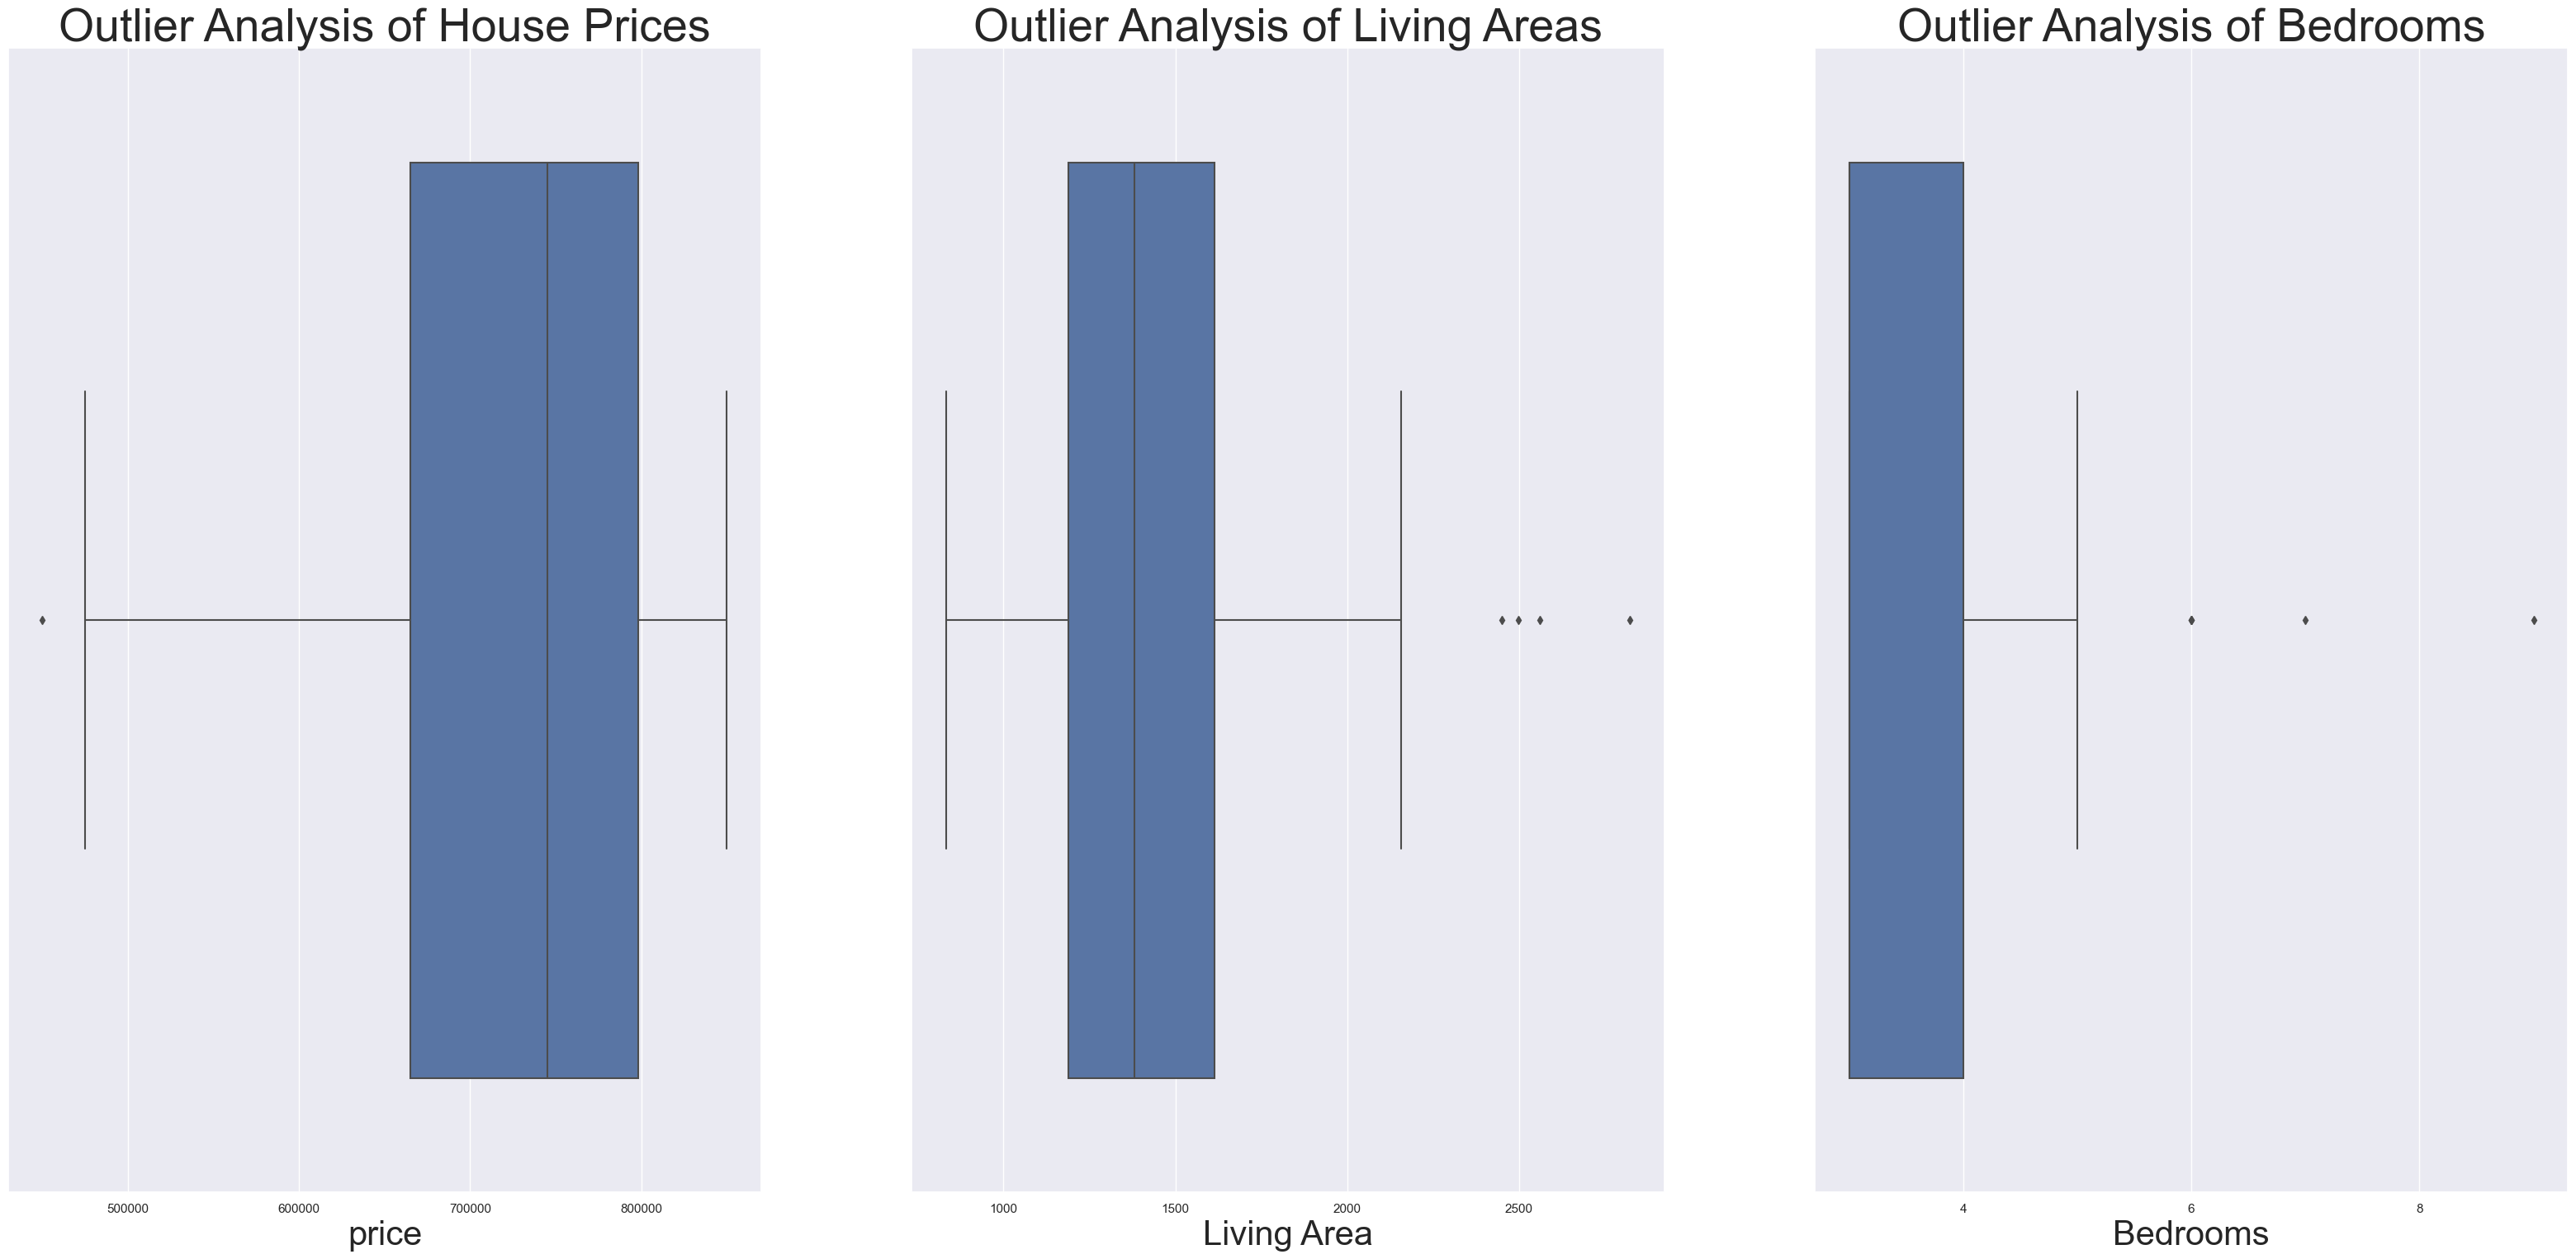

In [319]:
# identifying outliers:
fig, ax = plt.subplots(1, 3, figsize=(40,18))
sns.set(font_scale = 3)
ax1 = sns.boxplot(data= socal_list2, x= 'price', ax= ax[0])
ax1.set_xlabel('price', fontsize = 30)
ax1.set_title('Outlier Analysis of House Prices', fontsize = 40)
ax2 = sns.boxplot(data= socal_list2, x= 'livingArea', ax = ax[1])
ax2.set_xlabel('Living Area', fontsize = 30)
ax2.set_title('Outlier Analysis of Living Areas', fontsize = 40)
ax3 = sns.boxplot(data= socal_list2, x= 'bedrooms', ax = ax[2])
ax3.set_xlabel('Bedrooms', fontsize = 30)
ax3.set_title('Outlier Analysis of Bedrooms', fontsize = 40)


plt.show()

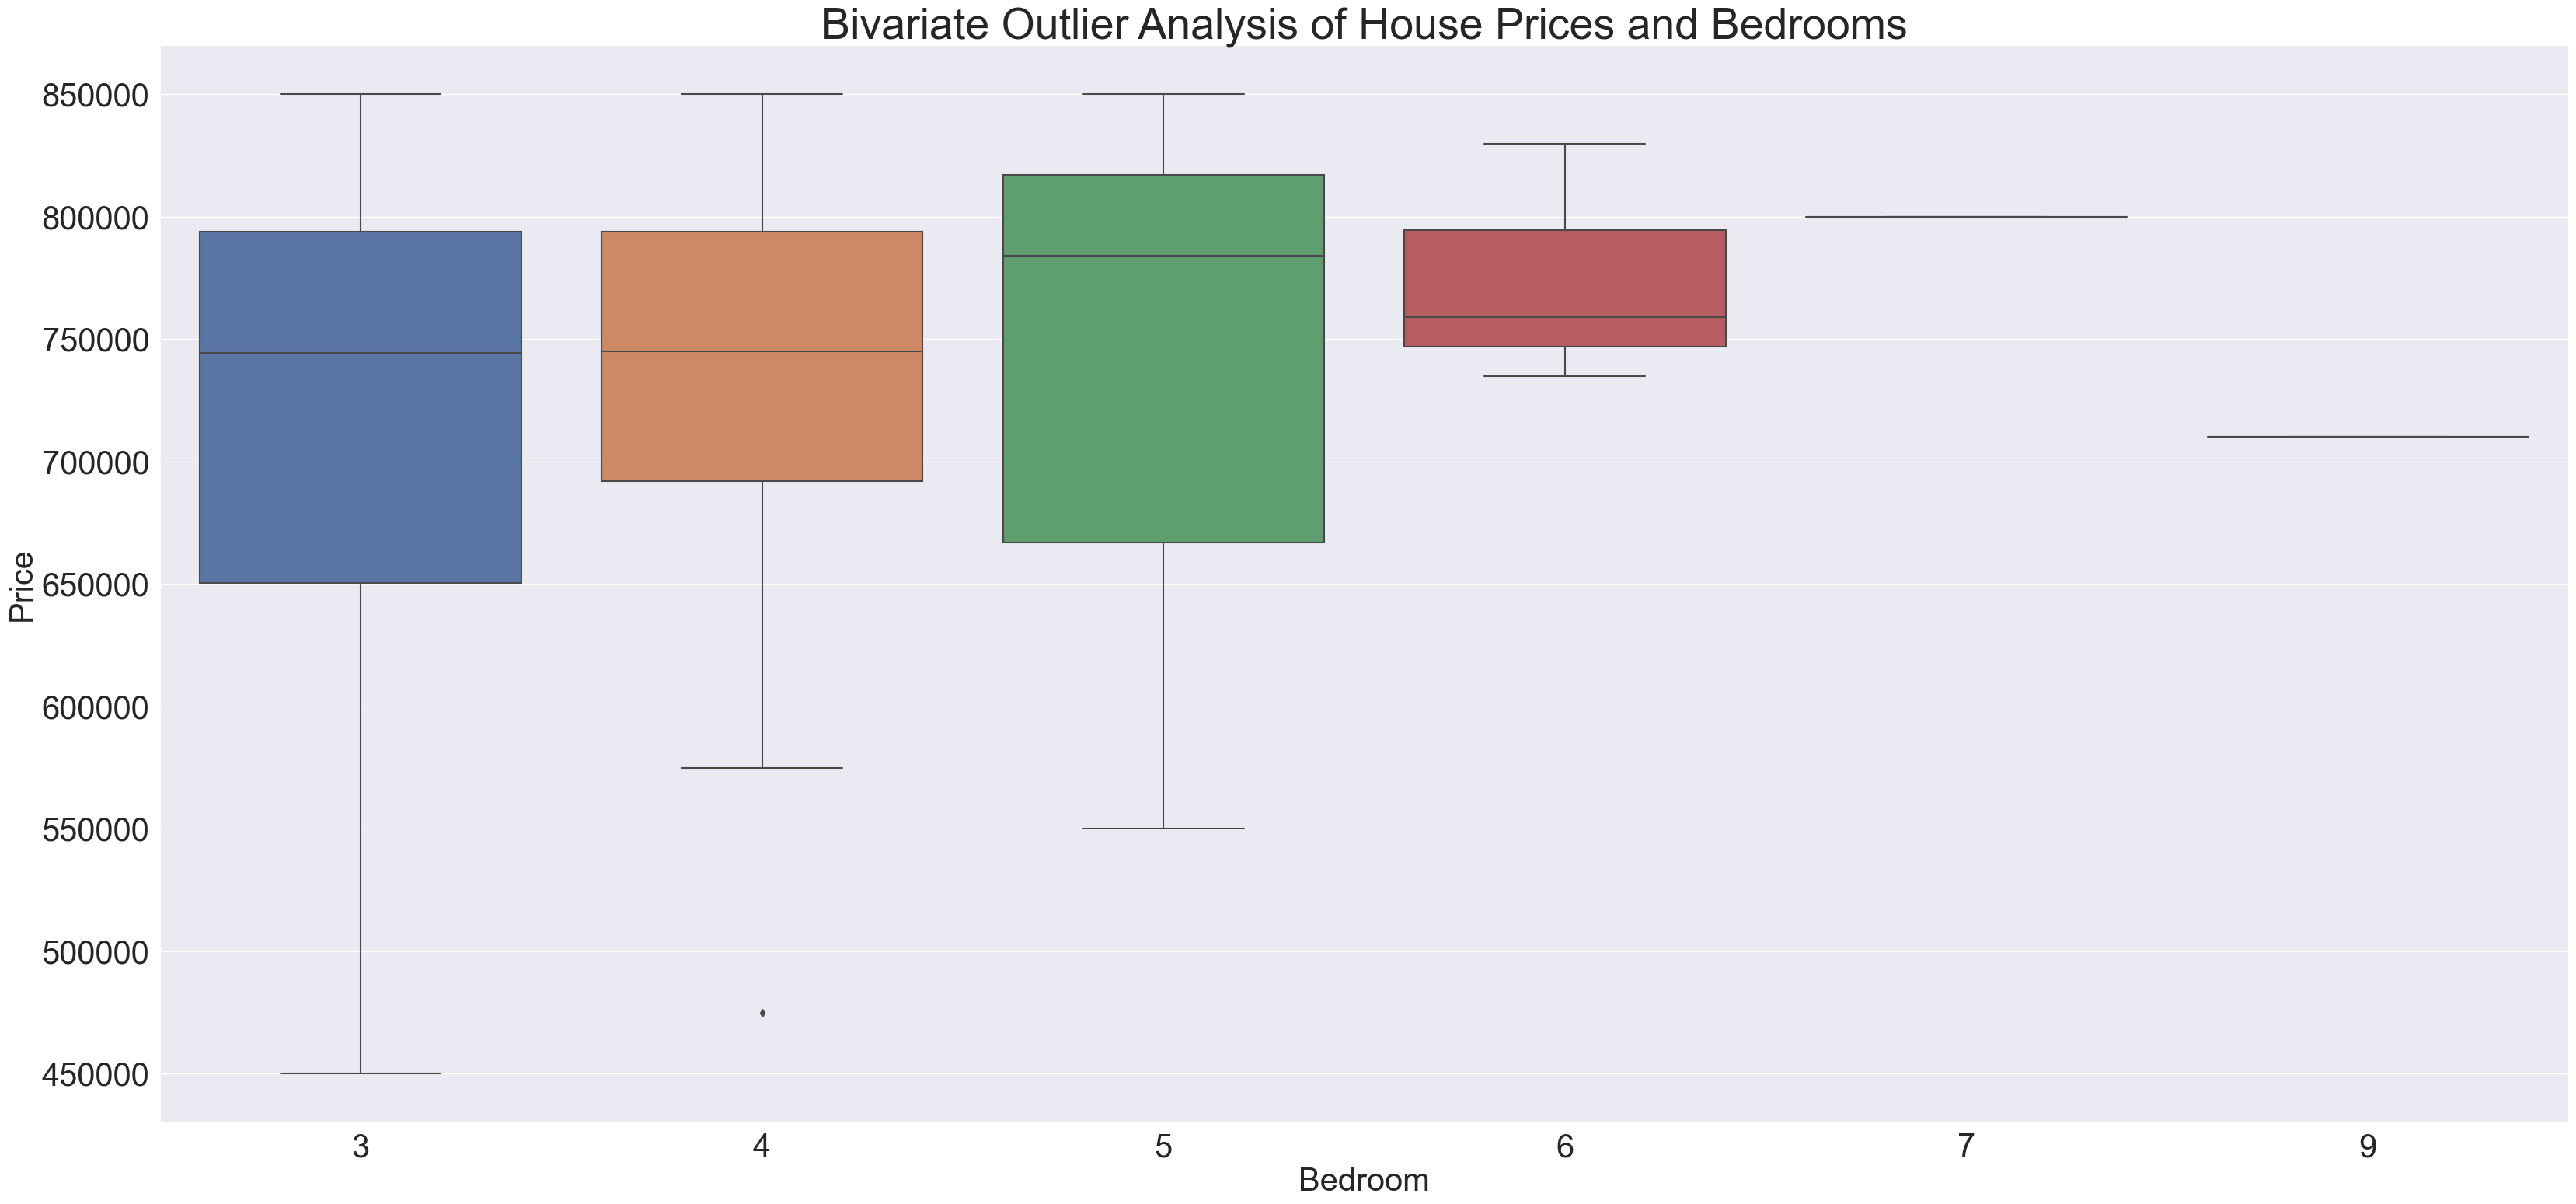

In [320]:
# Plot a boxplot to identify bivariate outliers:
plt.figure(figsize = (40,18))
ax = sns.boxplot(data= socal_list2, x='bedrooms', y='price')
ax.set_xlabel('Bedroom', fontsize = 30)
ax.set_ylabel('Price', fontsize = 30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
ax.set_title('Bivariate Outlier Analysis of House Prices and Bedrooms', fontsize = 40)

plt.show()

In [321]:
# create dataframe for identifying multivariate outliers:
socalre_pricedata = socal_list2[['price', 'livingArea', 'bedrooms', 'bathrooms']].copy()
socalre_pricedata.head()

,price,livingArea,bedrooms,bathrooms
0,675000,832,3,2
1,699900,1416,4,2
2,725000,1189,3,2
3,789900,1360,3,2
4,750000,1739,4,2


In [322]:
# Identify multivariate outliers:
scaler = StandardScaler()

socal_re_scaled = scaler.fit_transform(socalre_pricedata)
socal_re_scaled = pd.DataFrame(socal_list2, columns = socalre_pricedata.columns)
socal_re_scaled.head()

,price,livingArea,bedrooms,bathrooms
0,675000,832,3,2
1,699900,1416,4,2
2,725000,1189,3,2
3,789900,1360,3,2
4,750000,1739,4,2


In [323]:
# Calculate the Mahalanobis distance:
mean = socalre_pricedata.mean()
cov = socalre_pricedata.cov()
inv_cov = np.linalg.inv(cov)
distances = []
for _, x in socal_re_scaled.iterrows():
    d = mahalanobis(x, mean, inv_cov)
    distances.append(d)
socalre_pricedata['mahalanobis_distances'] = distances
socalre_pricedata

C:\Users\Angel\AppData\Local\Temp\ipykernel_26260\3082611572.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  socalre_pricedata['mahalanobis_distances'] = distances


,price,livingArea,bedrooms,bathrooms,mahalanobis_distances
0,675000,832,3,2,1.620500
1,699900,1416,4,2,1.230482
2,725000,1189,3,2,0.772109
3,789900,1360,3,2,0.964273
4,750000,1739,4,2,1.239152
...,...,...,...,...,...
84,775000,1767,3,2,1.368015
85,829000,1563,3,2,1.271082
86,805000,1722,3,2,1.313049
87,699000,1368,4,2,1.289702


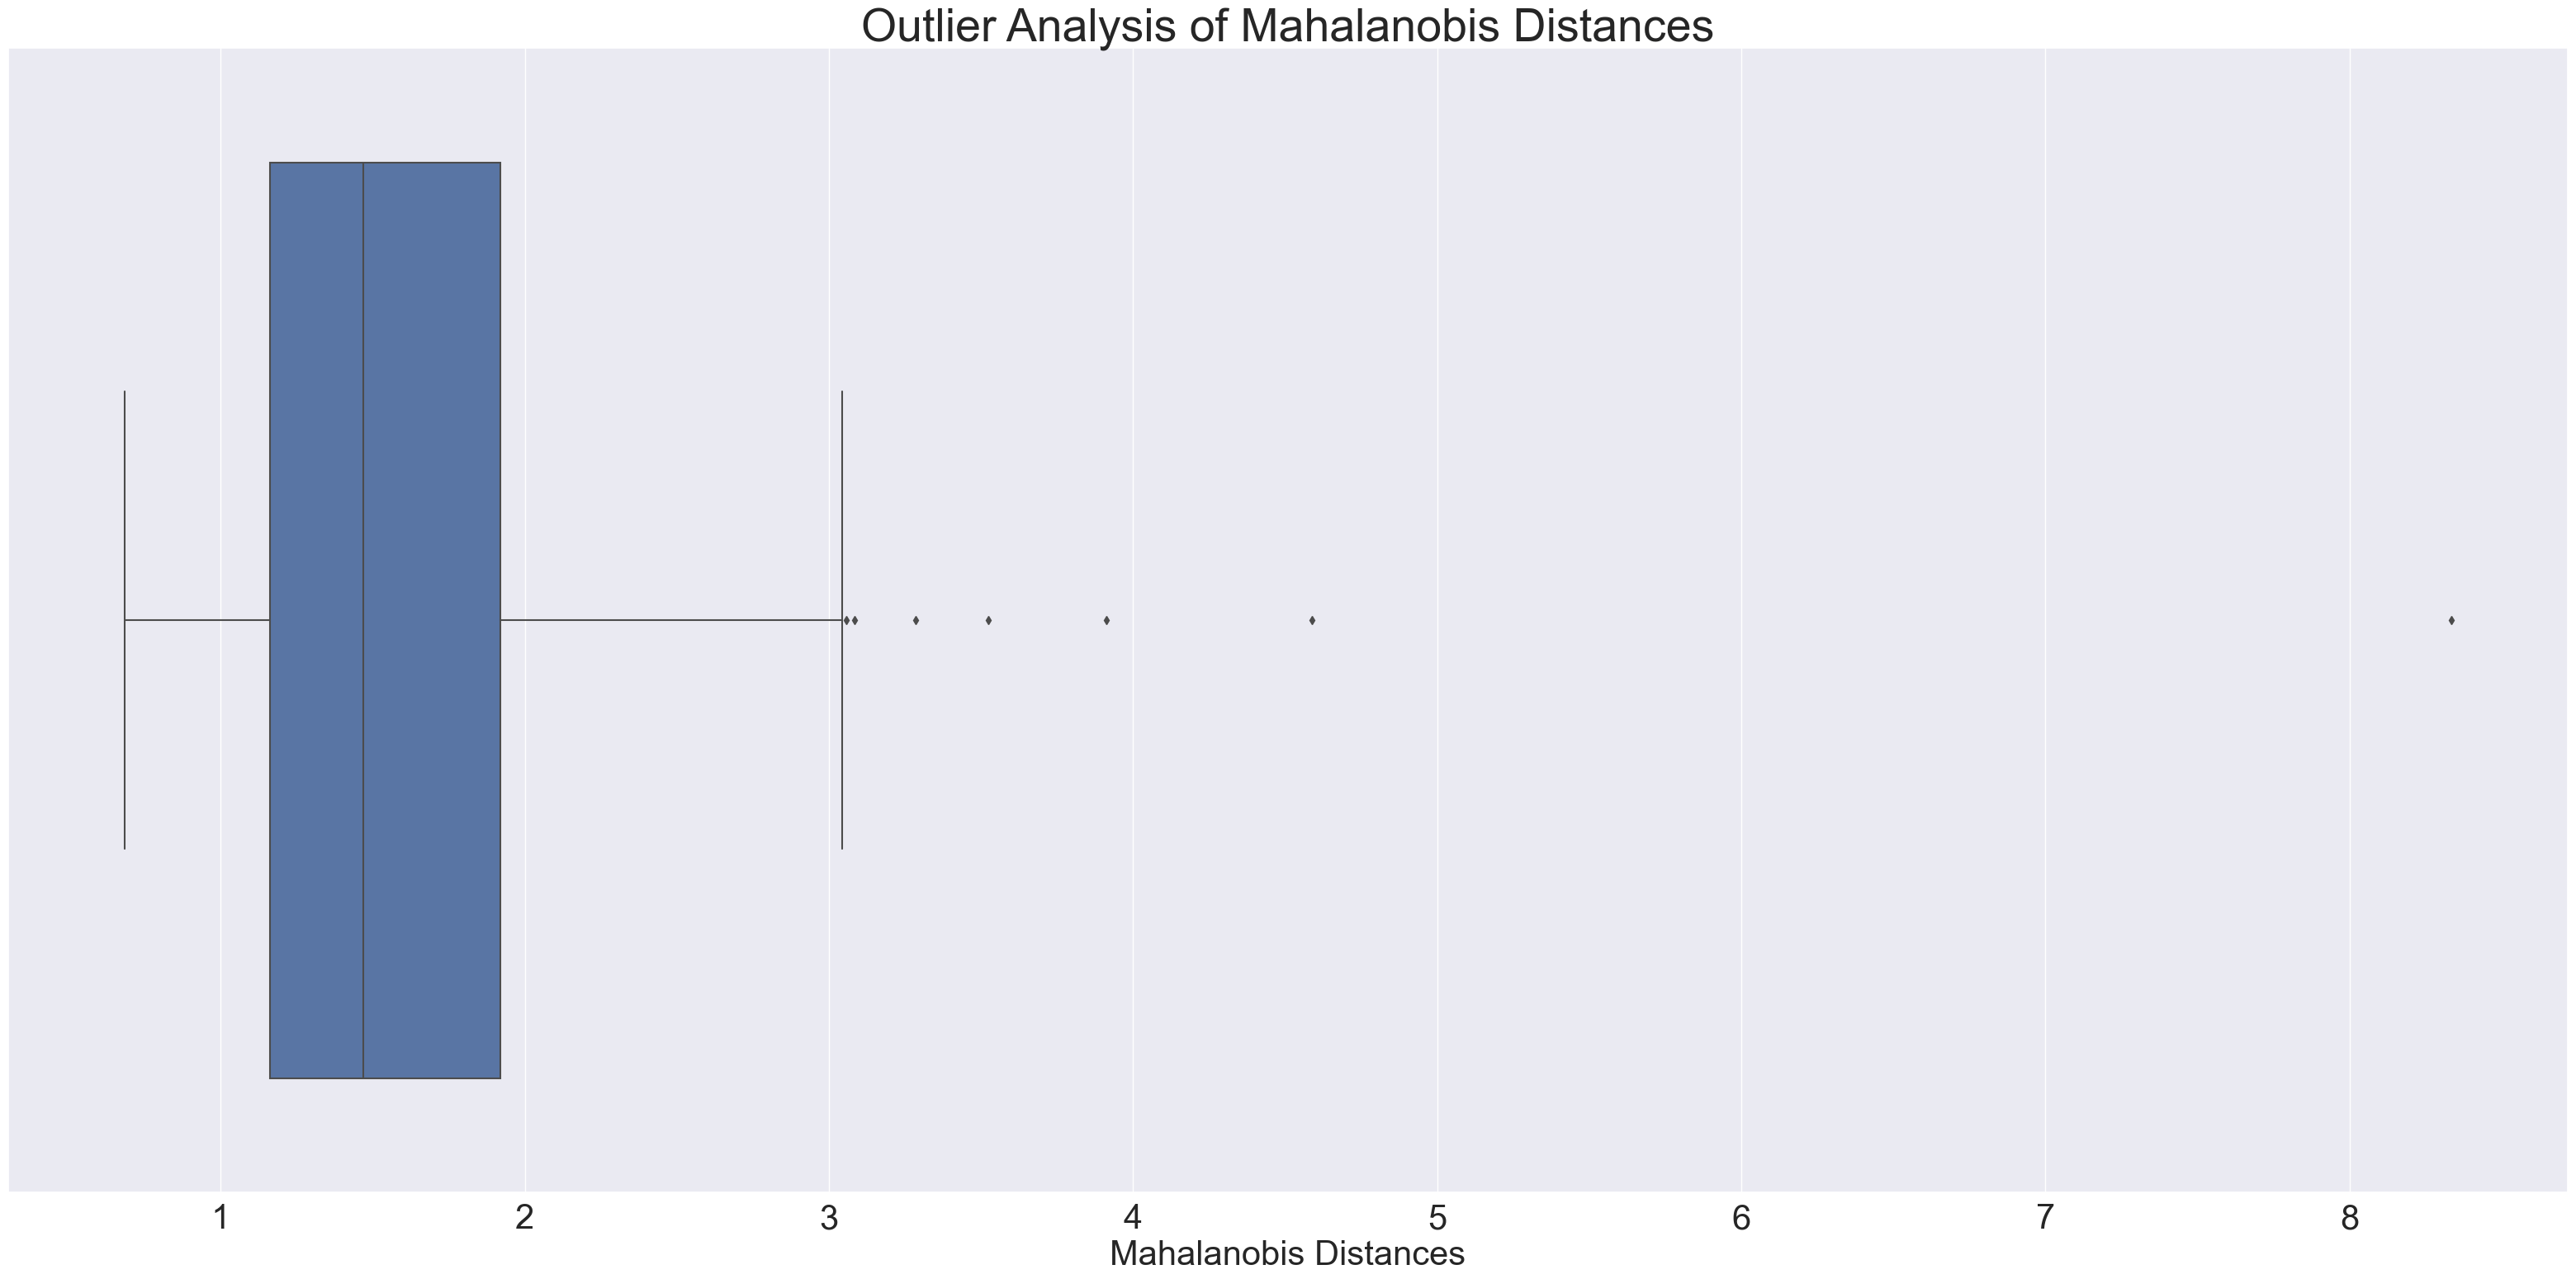

In [324]:
# Plot the Mahalanobis distances in boxplot to identify outliers:
plt.figure(figsize = (40,18))
ax = sns.boxplot(data = socalre_pricedata, x= 'mahalanobis_distances')
ax.set_xlabel('Mahalanobis Distances', fontsize = 30)
plt.xticks(fontsize = 30)
ax.set_title('Outlier Analysis of Mahalanobis Distances', fontsize = 40)
plt.show()

In [325]:
# Set threshold to identify outliers:
mahalanobis_outliers = socalre_pricedata[socalre_pricedata['mahalanobis_distances'] >=4]
mahalanobis_outliers.head()

,price,livingArea,bedrooms,bathrooms,mahalanobis_distances
60,799900,2498,7,3,4.588410
64,710000,1188,9,9,8.334902


In [326]:
# checking detail of outliers: 

#socal_list2.head()
bedroom_outliers = socal_list2.loc[(socal_list2['bedrooms'] > 6)]
bedroom_outliers

,zpid,streetName,city,state,zipcode,latitude,longitude,price,bathrooms,bedrooms,livingArea,homeType,lotAreaValue,datePriceChanged,priceReduction,priceChange
60,21008297,1008 N Willow Ave,Compton,CA,90221,33.902960,-118.21710,799900,3,7,2498,MULTI_FAMILY,5236.0,NaN,NaN,NaN
64,21008059,208 E Poplar St,Compton,CA,90220,33.900017,-118.22167,710000,9,9,1188,MULTI_FAMILY,4999.0,NaN,NaN,NaN


Since these outliers are multi-family units, I am going to remove them from the dataset. We are interested in possibly a small multi-family home but not a large multi-family home.

In [327]:
# Remove outliers from dataset:

socal_list_no_outliers = socal_list2.drop(bedroom_outliers.index, axis = 0)
socal_list_no_outliers.shape

(87, 16)

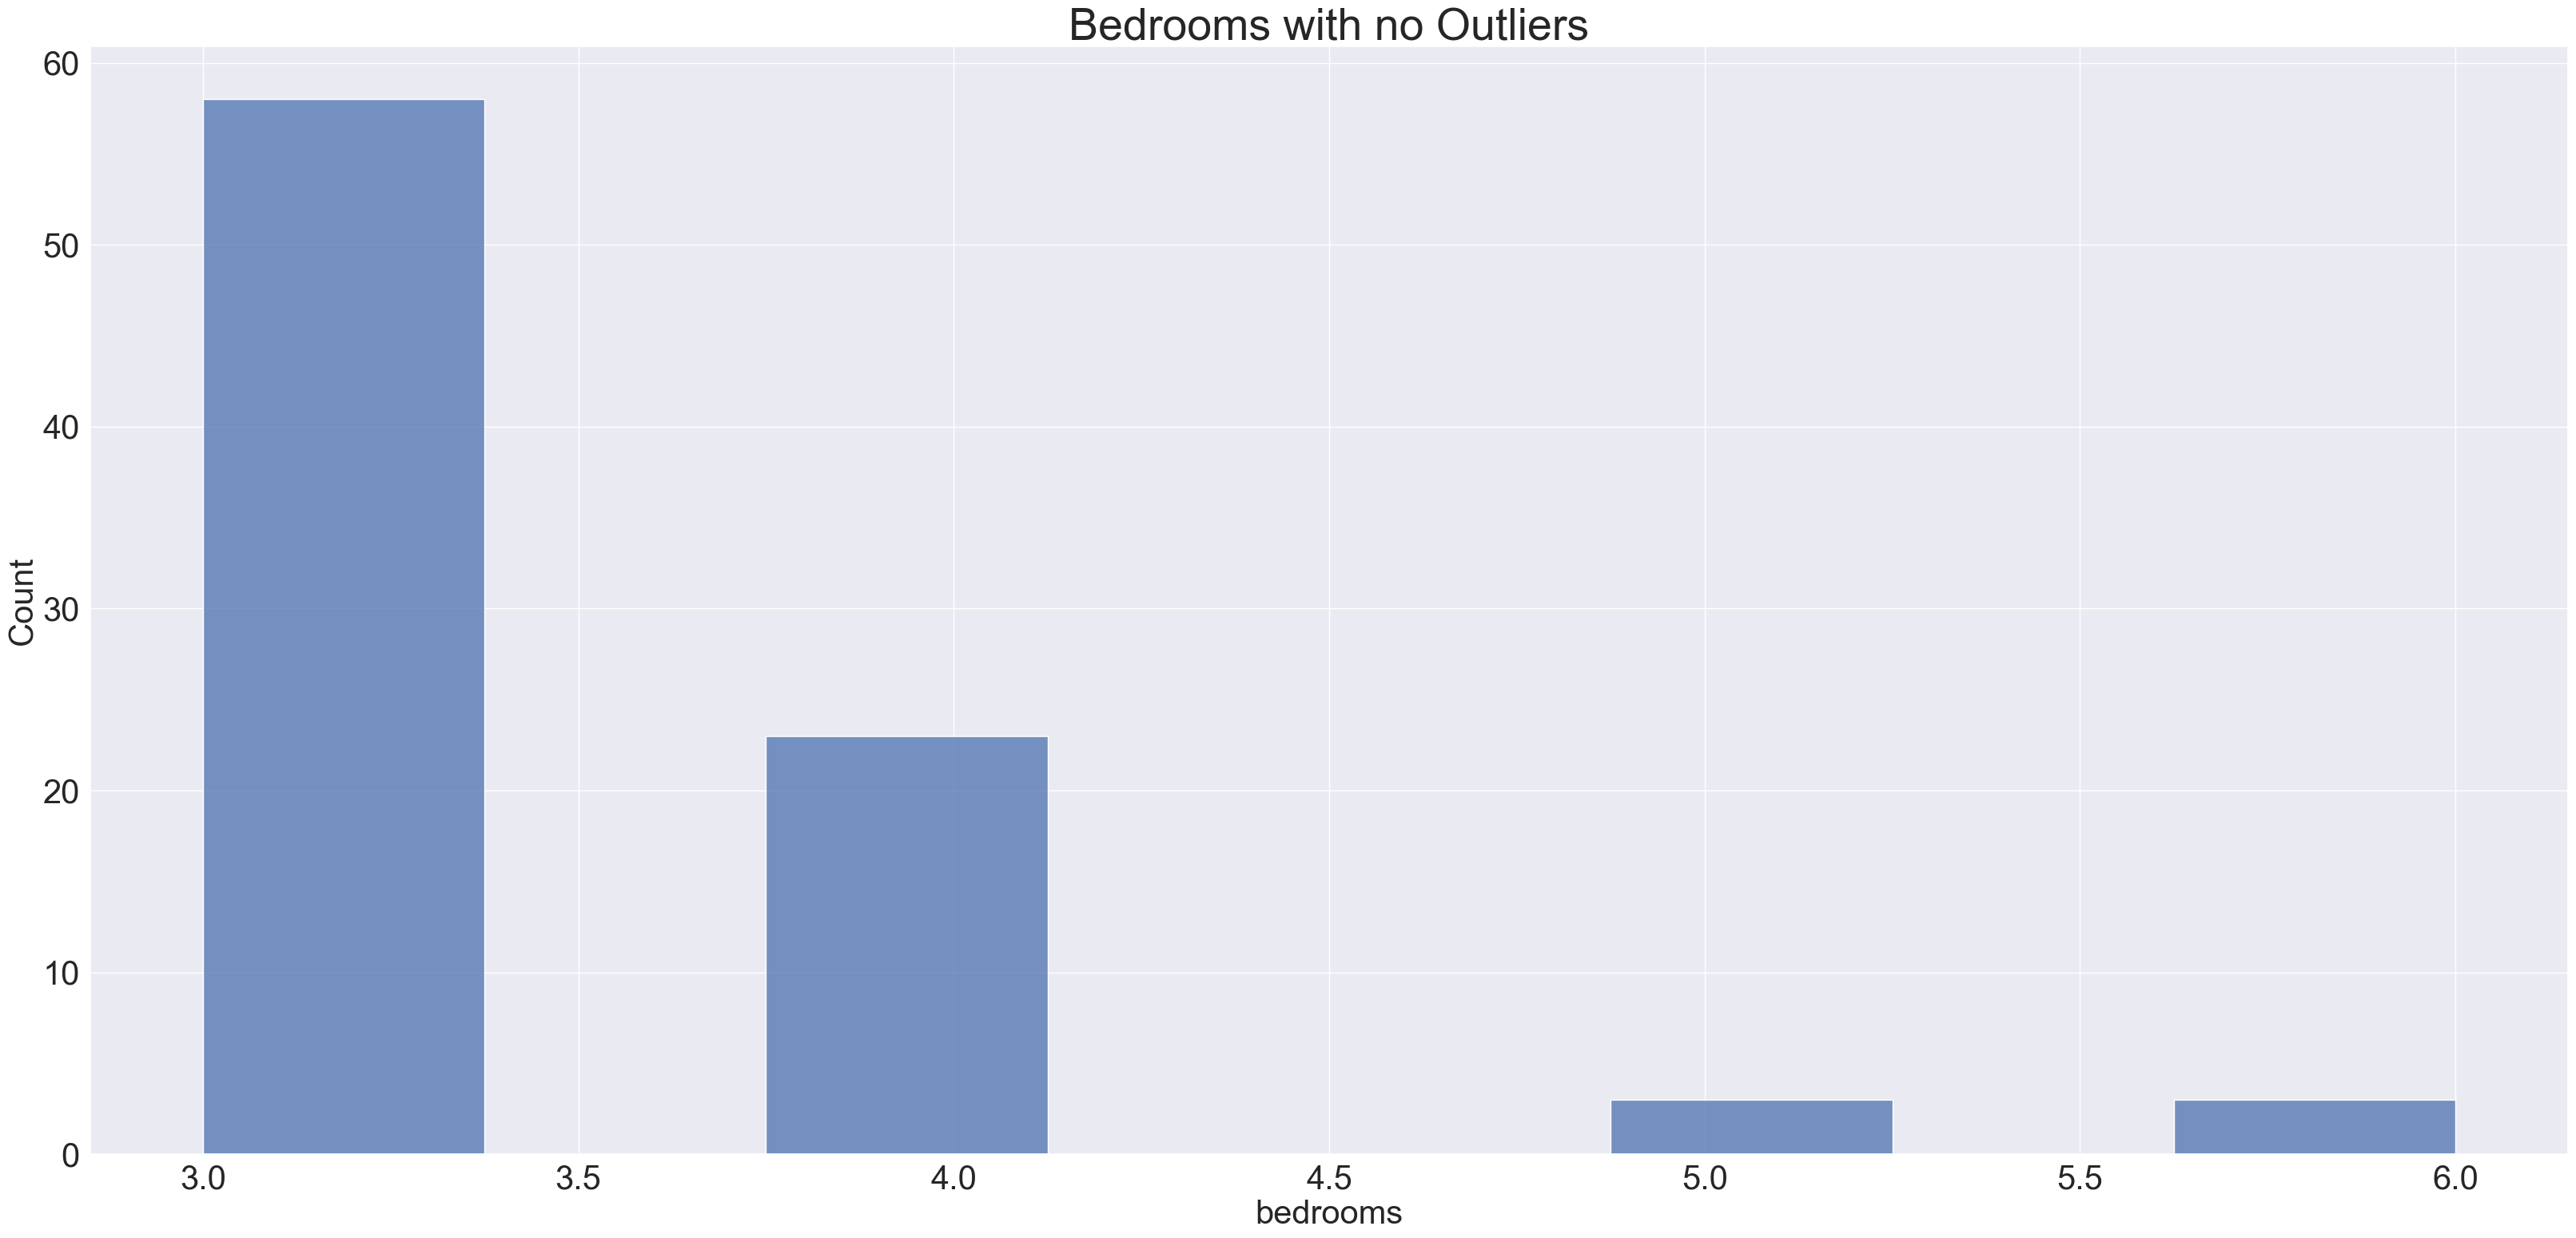

In [328]:
# histogram of data without outliers:
plt.figure(figsize = (40,18))
ax = sns.histplot(data= socal_list_no_outliers, x= 'bedrooms')
ax.set_xlabel('bedrooms', fontsize =30)
ax.set_title('Bedrooms with no Outliers', fontsize = 40)
ax.set_ylabel('Count', fontsize = 30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.show()

In [329]:
# Check for missing values:

socal_list_no_outliers.isnull().sum()

zpid                 0
streetName           0
city                 0
state                0
zipcode              0
latitude             0
longitude            0
price                0
bathrooms            0
bedrooms             0
livingArea           0
homeType             0
lotAreaValue         0
datePriceChanged    65
priceReduction      75
priceChange         65
dtype: int64

The only columns with missing data are the 'datePriceChanged', 'priceReduction', and 'priceChange'. Therefore, I decided to remove only the columns with missing data to finish cleaning this dataset.

In [330]:
# drop columns with missing values:
socal_listings_clean = socal_list_no_outliers.dropna(axis='columns')
socal_listings_clean.shape

(87, 13)

### Feature Relationships

Next, I will look at the relationships between the features latitude, longitude, price, bathrooms, bedrooms and living area.

In [426]:
# Correlation between numerical values:
socal_listings_corr = socal_listings_clean[['latitude', 'longitude', 'price', 'bathrooms',
                      'bedrooms', 'livingArea', 'lotAreaValue']].corr()
socal_listings_corr

,latitude,longitude,price,bathrooms,bedrooms,livingArea,lotAreaValue
latitude,1.000000,0.521381,0.008847,-0.035084,-0.057140,-0.059394,0.243498
longitude,0.521381,1.000000,0.426874,-0.159956,-0.275816,-0.165280,0.294317
price,0.008847,0.426874,1.000000,0.205546,0.081840,0.431468,0.321185
bathrooms,-0.035084,-0.159956,0.205546,1.000000,0.639159,0.509090,-0.003563
bedrooms,-0.057140,-0.275816,0.081840,0.639159,1.000000,0.500357,-0.008101
livingArea,-0.059394,-0.165280,0.431468,0.509090,0.500357,1.000000,0.137467
lotAreaValue,0.243498,0.294317,0.321185,-0.003563,-0.008101,0.137467,1.000000


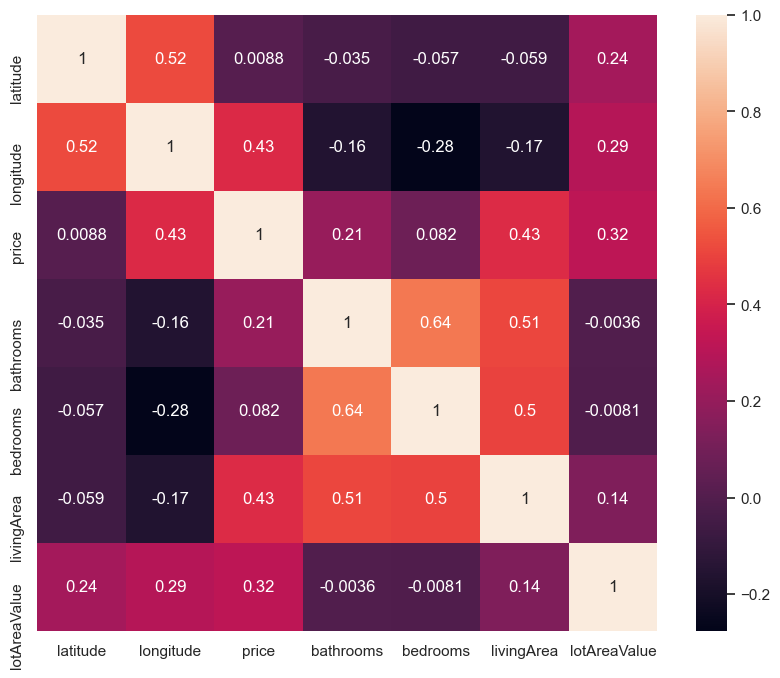

In [427]:
# Heat map of Correlation:
sns.set(rc = {'figure.figsize':(10, 8)})
sns.heatmap(socal_listings_corr, annot=True)
plt.show()

In this graph, the highest coorrelation to price is longitude and living area. However, one of the lowest correlations to price is bedrooms. 

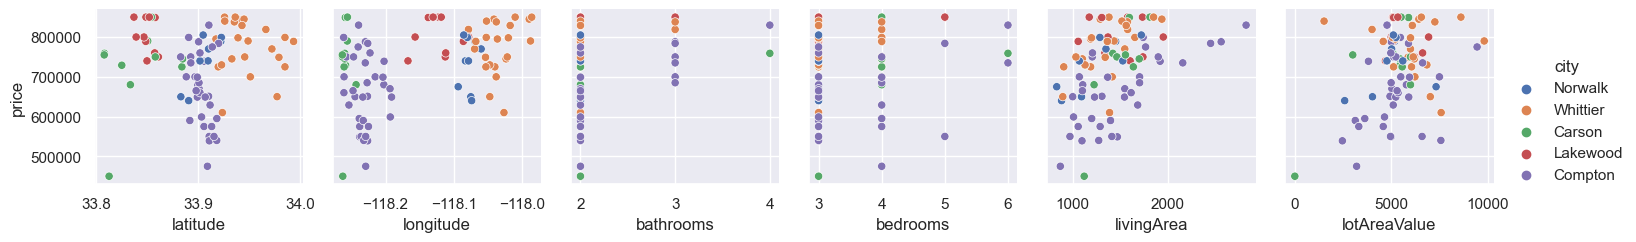

In [428]:
# Pair Grid of price compared to latitude, longitude, bathrooms bedrooms and living area:
g = sns.PairGrid(
    socal_listings_clean,
    hue="city",
    x_vars= ['latitude', 'longitude', 'bathrooms', 'bedrooms', 'livingArea', 'lotAreaValue'],
    y_vars= 'price'
)
g.map(sns.scatterplot)
g.add_legend()
plt.show()

This graph shows that most of the features have some correlation to price. However, bedrooms and lot area value does not seem to effect the price as much as the other features. For example, it is possible to get either a 3 or 4 bedroom home for roughly the same price. Therefore, I will focus on finding homes with the most bedrooms for the best value.

### Exploratory Data Analysis

What are the top 10 homes that have at least 4 bedrooms for the lowest price? 

In [425]:
 beds_price =  socal_listings_clean.loc[(socal_listings_clean['bedrooms'] > 3)] \
                        .sort_values('price').head(10)
beds_price

,zpid,streetName,city,state,zipcode,latitude,longitude,price,bathrooms,bedrooms,livingArea,homeType,lotAreaValue
24,21003690,13610 S Vesta Ave,Compton,CA,90222,33.909046,-118.229010,475000,2,4,870,SINGLE_FAMILY,3207.0
41,21001647,2021 E Lucien St,Compton,CA,90222,33.910770,-118.235680,550000,2,5,1412,SINGLE_FAMILY,4964.0
5,20986560,734 W 139th St,Compton,CA,90222,33.905666,-118.237780,575000,2,4,1289,MULTI_FAMILY,4588.0
49,21000175,1915 E 126th St,Compton,CA,90222,33.918280,-118.238464,595000,2,4,1200,SINGLE_FAMILY,3630.0
75,20997597,1913 W 133rd St,Compton,CA,90222,33.911660,-118.253550,629000,2,4,1684,SINGLE_FAMILY,5106.0
13,21253612,1629 E 215th Pl,Carson,CA,90745,33.833360,-118.243090,680000,2,4,1225,SINGLE_FAMILY,6002.0
67,2054065729,700 704 N Acacia St,Compton,CA,90220,33.900795,-118.226950,685000,3,4,1704,MULTI_FAMILY,4997.0
87,21015624,1802 E San Vincente St,Compton,CA,90221,33.899120,-118.203835,699000,2,4,1368,SINGLE_FAMILY,5951.0
66,21013269,119 N Chester Ave,Compton,CA,90221,33.896850,-118.215160,699900,3,4,1704,MULTI_FAMILY,7503.0
1,21438254,9345 Firebird Ave,Whittier,CA,90605,33.951202,-118.038216,699900,2,4,1416,SINGLE_FAMILY,6231.0


Text(0.5, 1.0, 'Homes with at Least 4 Bedrooms for Lowest Prices')

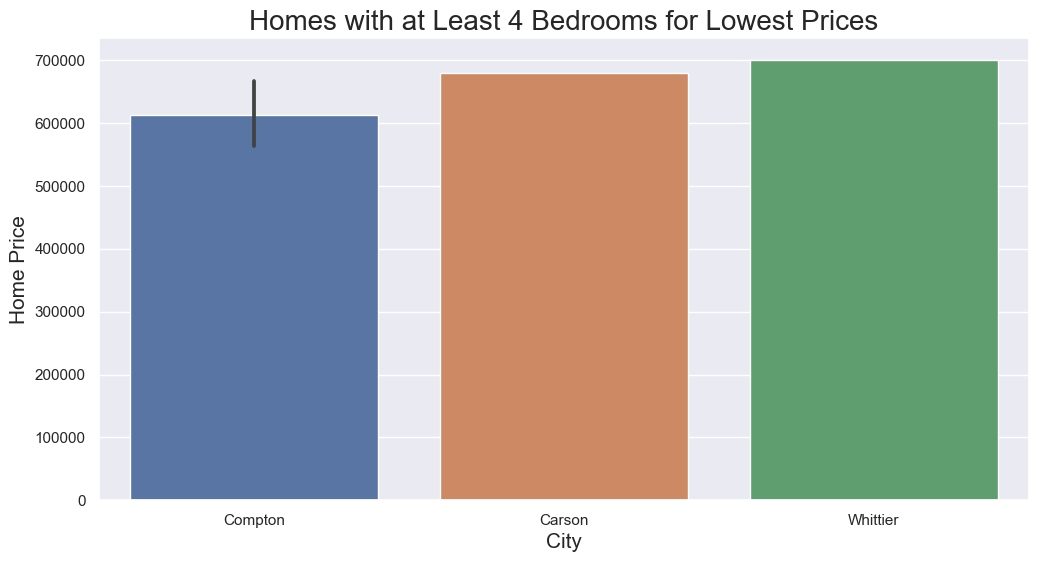

In [336]:
# plot beds_price using seaborn:
plt.figure(figsize = (12,6))
data = beds_price
ax = sns.barplot(data= beds_price, x='city', y='price')
ax.set_xlabel('City', fontsize = 15)
ax.set_ylabel('Home Price', fontsize = 15)
ax.set_title('Homes with at Least 4 Bedrooms for Lowest Prices', fontsize = 20)

What are the top 10 homes that have at least 4 bedrooms and the highest lot area value?

In [337]:
beds_lotAreaValue =  socal_listings_clean.loc[(socal_listings_clean['bedrooms'] > 3)] \
                            .sort_values('lotAreaValue', ascending = False).head(10)
beds_lotAreaValue

,zpid,streetName,city,state,zipcode,latitude,longitude,price,bathrooms,bedrooms,livingArea,homeType,lotAreaValue
66,21013269,119 N Chester Ave,Compton,CA,90221,33.896850,-118.215160,699900,3,4,1704,MULTI_FAMILY,7503.0
50,55198510,13728 Rancho Ln,Whittier,CA,90604,33.935490,-118.038030,838000,3,4,1576,SINGLE_FAMILY,7266.0
83,21006096,426 W Laurel St,Compton,CA,90220,33.892740,-118.229660,735000,3,6,2158,MULTI_FAMILY,6629.0
1,21438254,9345 Firebird Ave,Whittier,CA,90605,33.951202,-118.038216,699900,2,4,1416,SINGLE_FAMILY,6231.0
4,21174714,6121 Droxford St,Lakewood,CA,90713,33.860863,-118.112656,750000,2,4,1739,SINGLE_FAMILY,6216.0
30,21433524,10834 Valley View Ave,Whittier,CA,90604,33.933030,-118.023740,745000,2,4,1102,SINGLE_FAMILY,6197.0
13,21253612,1629 E 215th Pl,Carson,CA,90745,33.833360,-118.243090,680000,2,4,1225,SINGLE_FAMILY,6002.0
87,21015624,1802 E San Vincente St,Compton,CA,90221,33.899120,-118.203835,699000,2,4,1368,SINGLE_FAMILY,5951.0
33,21251880,19414 Campaign Dr,Carson,CA,90746,33.855125,-118.258840,849000,2,4,1596,SINGLE_FAMILY,5902.0
72,21000835,2611 E 124th St,Compton,CA,90222,33.920017,-118.226000,784000,3,5,2451,SINGLE_FAMILY,5896.0


Text(0.5, 1.0, 'Homes with at Least 4 Bedrooms and Highest Lot Area Value')

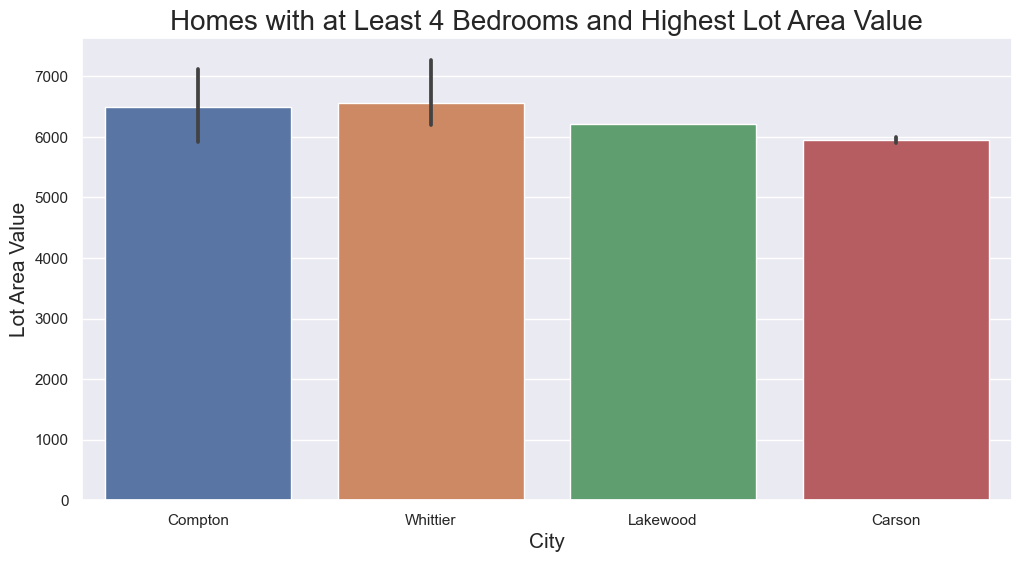

In [338]:
# plot beds_lotAreaValue with seaborn:
plt.figure(figsize = (12,6))
data = beds_lotAreaValue
ax = sns.barplot(data= beds_lotAreaValue, x='city', y='lotAreaValue')
ax.set_xlabel('City', fontsize = 15)
ax.set_ylabel('Lot Area Value', fontsize = 15)
ax.set_title('Homes with at Least 4 Bedrooms and Highest Lot Area Value', fontsize = 20)

I notice that the homes with at least 4 bedrooms and the highest lot area value, also have at least 1,100 sqft living area. What are the top 20 homes that has at least 1,100 sqft. for the lowest price?

In [339]:
livingArea_price = socal_listings_clean.loc[(socal_listings_clean['livingArea'] > 1100)] \
                            .sort_values('price').head(20)
livingArea_price

,zpid,streetName,city,state,zipcode,latitude,longitude,price,bathrooms,bedrooms,livingArea,homeType,lotAreaValue
17,21248370,43 Paradise Vall N,Carson,CA,90745,33.812447,-118.262490,450000,2,3,1121,SINGLE_FAMILY,1.0035
59,21000757,2301 E 126th St,Compton,CA,90222,33.918190,-118.231880,539999,2,3,1274,SINGLE_FAMILY,7578.0000
16,21001797,2204 N Anzac Ave,Compton,CA,90222,33.912500,-118.237770,549000,2,3,1470,SINGLE_FAMILY,4999.0000
41,21001647,2021 E Lucien St,Compton,CA,90222,33.910770,-118.235680,550000,2,5,1412,SINGLE_FAMILY,4964.0000
5,20986560,734 W 139th St,Compton,CA,90222,33.905666,-118.237780,575000,2,4,1289,MULTI_FAMILY,4588.0000
52,21006182,603 W Indigo St,Compton,CA,90220,33.891766,-118.232590,589999,2,3,1398,SINGLE_FAMILY,3136.3200
49,21000175,1915 E 126th St,Compton,CA,90222,33.918280,-118.238464,595000,2,4,1200,SINGLE_FAMILY,3630.0000
6,21378499,14331 Leffingwell Rd,Whittier,CA,90604,33.923714,-118.026830,610000,2,3,1388,SINGLE_FAMILY,7592.0000
75,20997597,1913 W 133rd St,Compton,CA,90222,33.911660,-118.253550,629000,2,4,1684,SINGLE_FAMILY,5106.0000
82,21002016,2080 E Oris St,Compton,CA,90222,33.906870,-118.233250,649000,2,3,1230,SINGLE_FAMILY,5912.0000


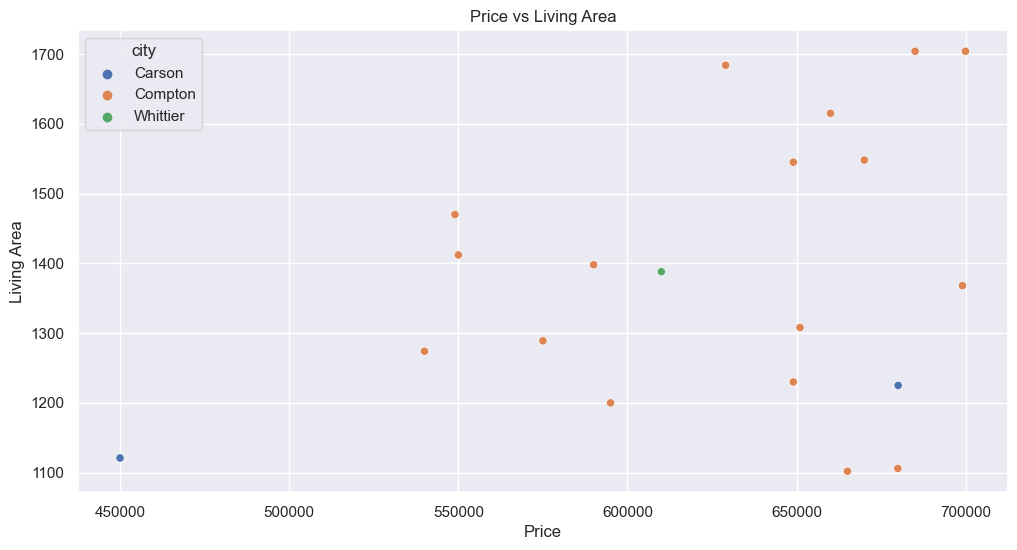

In [340]:
# Scatter plot of livingArea_price:
plt.figure(figsize = (12, 6))
ax = sns.scatterplot(data = livingArea_price, x='price', y='livingArea', hue="city")
ax.set_xlabel('Price') 
ax.set_ylabel('Living Area')
ax.set_title('Price vs Living Area')

plt.show()

My family and I have decided that we are more interested in living in either Carson or Whittier. Out of the homes in Carson and Whittier, which homes have 4+ bedrooms and living area greater than 1,100 sqft, for the lowest price?

In [365]:
# Finding homes in Carson and Whittier:
Carson_Whittier = socal_listings_clean[(socal_listings_clean['city'] == 'Carson') \
                    | (socal_listings_clean['city'] == 'Whittier')]
                                   
Carson_Whittier

,zpid,streetName,city,state,zipcode,latitude,longitude,price,bathrooms,bedrooms,livingArea,homeType,lotAreaValue
1,21438254,9345 Firebird Ave,Whittier,CA,90605,33.951202,-118.038216,699900,2,4,1416,SINGLE_FAMILY,6231.0000
2,21377623,12316 Newgate Ave,Whittier,CA,90605,33.919643,-118.040120,725000,2,3,1189,SINGLE_FAMILY,6057.0000
3,21284734,19922 Enslow Dr,Carson,CA,90746,33.850390,-118.256000,789900,2,3,1360,SINGLE_FAMILY,5070.3840
6,21378499,14331 Leffingwell Rd,Whittier,CA,90604,33.923714,-118.026830,610000,2,3,1388,SINGLE_FAMILY,7592.0000
12,21286192,813 E Lincoln St,Carson,CA,90745,33.807835,-118.259720,759000,4,6,1422,SINGLE_FAMILY,5092.1640
13,21253612,1629 E 215th Pl,Carson,CA,90745,33.833360,-118.243090,680000,2,4,1225,SINGLE_FAMILY,6002.0000
14,21257392,923 E Joel St,Carson,CA,90745,33.824920,-118.258420,729000,2,3,1130,SINGLE_FAMILY,5448.0000
17,21248370,43 Paradise Vall N,Carson,CA,90745,33.812447,-118.262490,450000,2,3,1121,SINGLE_FAMILY,1.0035
19,21466669,16030 La Calma Dr,Whittier,CA,90603,33.948980,-117.988014,790000,2,3,1435,SINGLE_FAMILY,9826.0000
22,59249122,8492 Millergrove Dr,Whittier,CA,90606,33.966454,-118.078766,819000,3,4,1578,SINGLE_FAMILY,4007.0000


In [429]:
ideal_homes = Carson_Whittier.loc[(Carson_Whittier['bedrooms'] > 3) & (Carson_Whittier['livingArea'] >= 1100)] \
                            .sort_values('price')
ideal_homes.head(3)

,zpid,streetName,city,state,zipcode,latitude,longitude,price,bathrooms,bedrooms,livingArea,homeType,lotAreaValue
13,21253612,1629 E 215th Pl,Carson,CA,90745,33.833360,-118.243090,680000,2,4,1225,SINGLE_FAMILY,6002.0
1,21438254,9345 Firebird Ave,Whittier,CA,90605,33.951202,-118.038216,699900,2,4,1416,SINGLE_FAMILY,6231.0
35,20994308,16306 Haskins Ln,Carson,CA,90746,33.883970,-118.260610,725000,2,4,1638,SINGLE_FAMILY,5571.0


Finally, we have a list of 3 homes that would fit our needs and budget for beginning our search for our first home.